In [2]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
class RobotAgent(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.caja = ()
        self.objetivo = ()

    def step(self):
        pasos = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        
        # Buscar una caja en la vecindad
        for step in pasos:
            x, y = step
            if self.model.cajas[x][y] > 0:
                self.recolecta(step)
                return
        
        # Si no hay cajas, moverse a una posición aleatoria vacía
        self.move_to_empty()

    def recolecta(self, position):
        x, y = position
        self.model.cajas[x][y] += 1
        self.model.cajas_recogidas += 1

    def move_to_empty(self):
        pasos = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        pasos_vacios = [step for step in pasos if self.model.grid.is_cell_empty(step)]
        if pasos_vacios:
            actualiza_pos = random.choice(pasos_vacios)
            self.model.grid.move_agent(self, actualiza_pos)


In [4]:
def getRobots(model):
    return np.asarray([agent.pos for agent in model.schedule.agents])

def getBoxes(model):
    return model.cajas

In [5]:
class AlmacenModel(Model):
    def __init__(self, width, height, num_agents, boxes):
        self.schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(width, height, torus=False)
        self.cajas = np.zeros((width, height), dtype=int)
        self.cajas_recogidas = 0
        self.datacollector = DataCollector(model_reporters={"Robots": getRobots, "Cajas": getBoxes})
        
        # Inicialización del modelo
        self.setup_model(num_agents, boxes)

    def setup_model(self, num_agents, boxes):
        # Colocación aleatoria de cajas y agentes
        self.cajas_aleatorias(boxes)
        self.agentes_aleatorios(num_agents)

    def cajas_aleatorias(self, boxes):
        for _ in range(boxes):
            x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            while self.cajas[x, y] >= 3:
                x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            self.cajas[x, y] += 1

    def agentes_aleatorios(self, num_agents):
        for i in range(num_agents):
            x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            while not self.grid.is_cell_empty((x, y)):
                x, y = self.random.randrange(self.grid.width), self.random.randrange(self.grid.height)
            agent = RobotAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x, y))

    def step(self):
        self.datacollector.collect(self)

        if not self.distribucion_caja():
            self.orden_caja()

        self.schedule.step()

    def distribucion_caja(self):
        return np.all(self.cajas % 5 == 0)

    def orden_caja(self):
        for agent in self.schedule.agents:
            if len(agent.caja) == 0:
                self.agente_vacio(agent)

    def agente_vacio(self, agent):
        pasos = self.grid.get_neighborhood(agent.pos, moore=False, include_center=False)
        pasos_vacios = [step for step in pasos if self.grid.is_cell_empty(step)]
        if pasos_vacios:
            actualiza_pos = random.choice(pasos_vacios)
            self.grid.move_agent(agent, actualiza_pos)


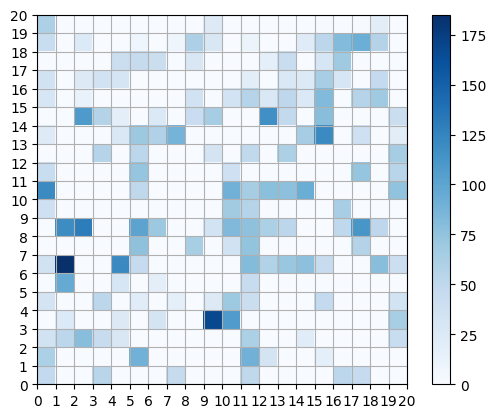

In [6]:
# Parámetros del modelo
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
ITERATIONS = 2000
BOXES = 200
SEED = 67890

random.seed(SEED)

model = AlmacenModel(WIDTH, HEIGHT, NUM_AGENTS, BOXES)

for i in range(ITERATIONS):
    model.step()

pos_final = model.datacollector.get_model_vars_dataframe()["Cajas"].iloc[-1]

cmap = plt.cm.Blues  

plt.imshow(pos_final, cmap=cmap, interpolation='nearest', origin='lower', extent=[0, WIDTH, 0, HEIGHT])
plt.colorbar()
plt.xticks(np.arange(0, HEIGHT+1, 1))
plt.yticks(np.arange(0, WIDTH+1, 1))
plt.grid(True)
plt.show()